In [20]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [15]:
# Load data
# Example: Assuming you have a CSV file with 'date' and 'layoffs' columns
data = pd.read_csv('/Users/asaifali/Downloads/layoffs_data(2).csv')
data

,Company,Location_HQ,Industry,Percentage,Date,Source,Funds_Raised,Stage,Date_Added,Country,Laid_Off_Count,List_of_Employees_Laid_Off
0,Farfetch,London,Retail,0.25,2024-02-16,https://ominho.pt/depois-da-saida-do-ceo-de-gu...,1700.0,Acquired,2024-02-16 18:39:00,United Kingdom,NaN,Unknown
1,Toast,Boston,Food,0.10,2024-02-15,https://www.bloomberg.com/news/articles/2024-0...,962.0,Post-IPO,2024-02-15 16:48:04,United States,550.0,Unknown
2,Storytel,Stockholm,Consumer,0.13,2024-02-15,https://investors.storytel.com/en/wp-content/u...,312.0,Post-IPO,2024-02-16 18:37:24,Sweden,80.0,Unknown
3,Gro Intelligence,New York City,Food,0.10,2024-02-15,https://agfundernews.com/ai-powered-ag-insight...,118.0,Series B,2024-02-16 18:35:19,United States,20.0,Unknown
4,CodeSee,SF Bay Area,Data,1.00,2024-02-15,https://www.linkedin.com/posts/shaneak_i-am-ve...,10.0,Seed,2024-02-15 19:34:43,United States,NaN,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
3449,Service,Los Angeles,Travel,1.00,2020-03-16,https://techcrunch.com/2020/03/16/travel-savin...,5.1,Seed,2020-08-31 15:17:26,United States,NaN,Unknown
3450,HopSkipDrive,Los Angeles,Transportation,0.10,2020-03-13,https://layoffs.fyi/2020/04/02/hopskipdrive-la...,45.0,Unknown,2020-04-03 04:47:03,United States,8.0,Unknown
3451,Panda Squad,SF Bay Area,Consumer,0.75,2020-03-13,https://twitter.com/danielsinger/status/123854...,1.0,Seed,2020-04-17 00:12:49,United States,6.0,Unknown
3452,Tamara Mellon,Los Angeles,Retail,0.40,2020-03-12,https://layoffs.fyi/list/tamara-mellon/,90.0,Series C,2020-03-31 16:04:23,United States,20.0,Unknown


In [16]:
data.dropna(subset=['Laid_Off_Count'], inplace=True)
# Drop columns
columns_to_drop = ['Percentage','List_of_Employees_Laid_Off','Company','Source','Date_Added']  # List of column names to drop
data.drop(columns=columns_to_drop, inplace=True)

In [17]:
data.dropna(subset=['Funds_Raised'], inplace=True)

In [18]:
data

,Location_HQ,Industry,Date,Funds_Raised,Stage,Country,Laid_Off_Count
1,Boston,Food,2024-02-15,962.0,Post-IPO,United States,550.0
2,Stockholm,Consumer,2024-02-15,312.0,Post-IPO,Sweden,80.0
3,New York City,Food,2024-02-15,118.0,Series B,United States,20.0
6,SF Bay Area,Infrastructure,2024-02-14,2.0,Post-IPO,United States,4250.0
7,Nashik,Finance,2024-02-14,16.0,Series A,India,19.0
...,...,...,...,...,...,...,...
3448,Austin,Support,2020-03-16,6.0,Seed,United States,16.0
3450,Los Angeles,Transportation,2020-03-13,45.0,Unknown,United States,8.0
3451,SF Bay Area,Consumer,2020-03-13,1.0,Seed,United States,6.0
3452,Los Angeles,Retail,2020-03-12,90.0,Series C,United States,20.0


In [19]:
# Label Encoding for a single column
label_encoder = LabelEncoder()
data['Location_HQ'] = label_encoder.fit_transform(data['Location_HQ'])
data['Industry'] = label_encoder.fit_transform(data['Industry'])
data['Funds_Raised'] = label_encoder.fit_transform(data['Funds_Raised'])
data['Stage'] = label_encoder.fit_transform(data['Stage'])
data['Country'] = label_encoder.fit_transform(data['Country'])
print("Label Encoded Data:")
print(data)

Label Encoded Data:
      Location_HQ  Industry        Date  Funds_Raised  Stage  Country  \
1              20        10  2024-02-15           563      1       45   
2             140         3  2024-02-15           299      1       39   
3             104        10  2024-02-15           132      5       45   
6             121        14  2024-02-14             4      1       45   
7              99         8  2024-02-14            23      4       17   
...           ...       ...         ...           ...    ...      ...   
3448            6        27  2020-03-16            10      3       45   
3450           84        28  2020-03-13            56     15       45   
3451          121         3  2020-03-13             3      3       45   
3452           84        24  2020-03-12           103      6       45   
3453          123        16  2020-03-11            17      4       45   

      Laid_Off_Count  
1              550.0  
2               80.0  
3               20.0  
6          

In [ ]:
# Rename columns to match Prophet's expected format
data = data.rename(columns={'Date': 'ds', 'Laid_Off_Count': 'y'})

In [21]:
# Define hyperparameters to tune
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

In [22]:
# Generate all possible combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid))

In [23]:
# Initialize variables to store best parameters and corresponding MAE
best_mae = float('inf')
best_params = None

In [ ]:
# Iterate over each combination of hyperparameters
for params in param_combinations:
    # Initialize Prophet model with current set of hyperparameters
    model = Prophet(daily_seasonality=True, **params)
    
    # Fit the model to your data
    model.fit(data)
    
    # Specify the number of periods to forecast into the future
    future_periods = 30  # for example, forecast for the next 30 days
    
    # Make future predictions
    future = model.make_future_dataframe(periods=future_periods)
    forecast = model.predict(future)
    
    # Calculate evaluation metrics
    actual_values = data['y']
    forecasted_values = forecast.set_index('ds')['yhat'].loc[data['ds']]
    mae = mean_absolute_error(actual_values, forecasted_values)
    mse = mean_squared_error(actual_values, forecasted_values)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual_values, forecasted_values)
    
    # Check if current MAE is the best so far
    if mae < best_mae:
        best_mae = mae
        best_params = params
        best_forecast = forecast


In [32]:
# Print best hyperparameters and corresponding MAE
print("Best Hyperparameters:", best_params)
print("Best Mean Absolute Error (MAE):", best_mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared Score: {:.2f}".format(r2))

Best Hyperparameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Best Mean Absolute Error (MAE): 261.948705518006
Mean Squared Error (MSE): 572616.8967155066
Root Mean Squared Error (RMSE): 756.7145411021957
R-squared Score: 0.04


/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pand

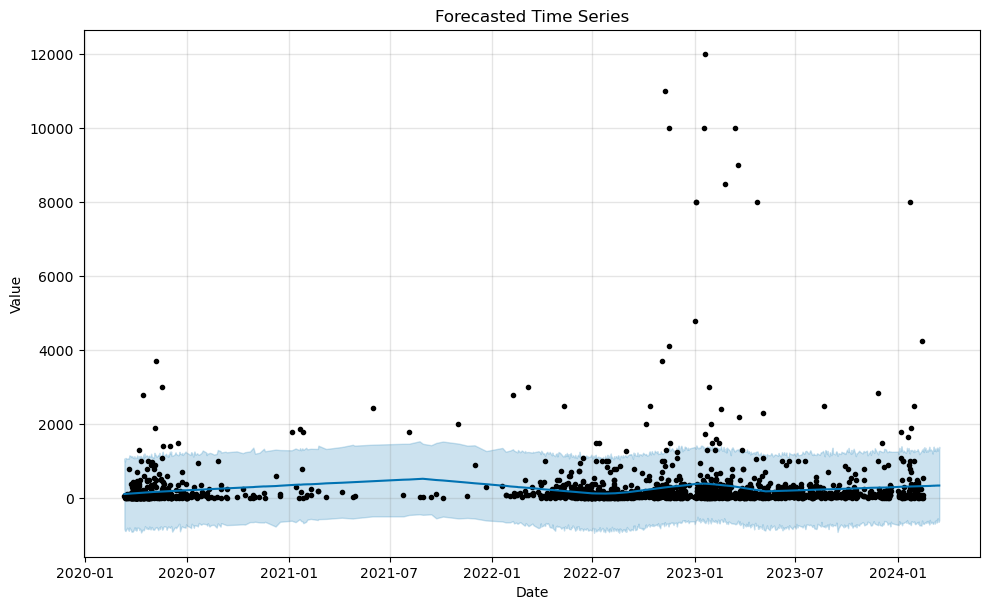

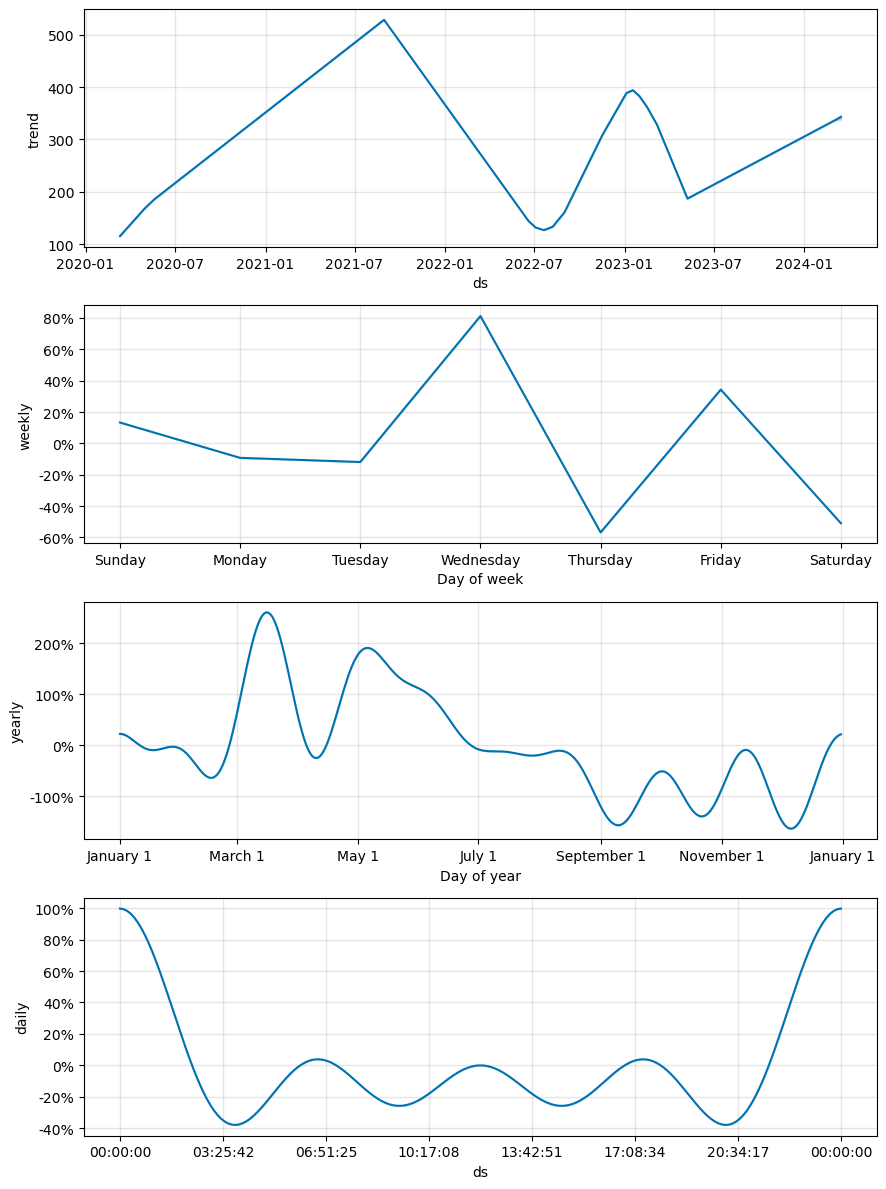

In [33]:
# Plot the forecast
fig1 = model.plot(best_forecast)
plt.title('Forecasted Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)

fig2 = model.plot_components(best_forecast)
# Show the plot
plt.show()